In [201]:
from general import *

In [202]:
class MotionNeuron():
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(MotionNeuron, self).__init__()
        self.tau = parameters['tau']
        self.V_R = parameters['V_R']
        self.V_T = parameters['V_T']
        self.w = parameters['w']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.V_R),
                                          w=np.array(self.w),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
        V = self.state.V
        w = self.state.w
        I = self.state.I

        V += self.dt*(self.V_R-V)/self.tau
        V += w * input

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R 

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [203]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = pickle.load(file) 
    
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

motion_parameters = {'tau': 5e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'] * parameters['N_HAIRS'], 'w': 10.5e-3,
                     'N_input': 1, 'dt': constants['dt'], 'refrac': 0}

motion_neuron = MotionNeuron(motion_parameters)
motion_neuron.initialize_state()

spike_motion_inter = np.empty((constants['N_STEPS'], motion_parameters['n'], parameters['N_SIMULATIONS']))
spike_motion = np.empty((constants['N_STEPS'], 2 * constants['N_ANGLES'], parameters['N_SIMULATIONS']))

In [204]:
for k in range(parameters['N_SIMULATIONS']):    
    for i in range(constants['N_STEPS']):
        _, spike_motion_inter[i, :, k] = motion_neuron.forward(spike_sensory[i, :, k])
        
        spike_motion[i, :, k] = np.sum(spike_motion_inter[i, :, k].reshape(2*constants['N_ANGLES'], parameters['N_HAIRS']), axis=1)
        spike_motion[i, :, k][spike_motion[i, :, k] > 1 ] = 1
        
with open('data/spike_motion', 'wb') as file:
        pickle.dump(spike_motion, file)

In [205]:
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 
     
joint_velocity = np.diff(joint_angles_nostep[:, :, :parameters['N_SIMULATIONS']], axis=0)
joint_velocity_up = np.heaviside(joint_velocity, 0)
joint_velocity_down = 1 - joint_velocity_up

true_positive, false_positive, _, _ = get_confusion_matrix(spike_motion[1:, 1::2], joint_velocity_up)
true_negative, false_negative, _, _ = get_confusion_matrix(spike_motion[1:, 0::2], joint_velocity_down)

statistical_data = get_statistics(true_positive, true_negative, false_positive, false_negative)

statistical_data_string = ['true positive', 'true negative', 'false positive', 'false negative', 'positives', 'negatives', 'total', 'MCC', 'accuracy', 'TPR', 'TNR']

table = {'value': np.around(statistical_data, 3)}
df = pd.DataFrame(data=table, index=['true positive', 'true negative', 'false positive', 'false negative', 'positives', 'negatives', 'total', 'MCC', 'accuracy', 'TPR', 'TNR'])
df.to_csv('results/motion_accuracy_table.csv')

print(df)

                    value
true positive   33943.000
true negative   34197.000
false positive   2404.000
false negative   2452.000
positives       36395.000
negatives       36601.000
total           72996.000
MCC                 0.867
accuracy            0.933
TPR                 0.933
TNR                 0.934


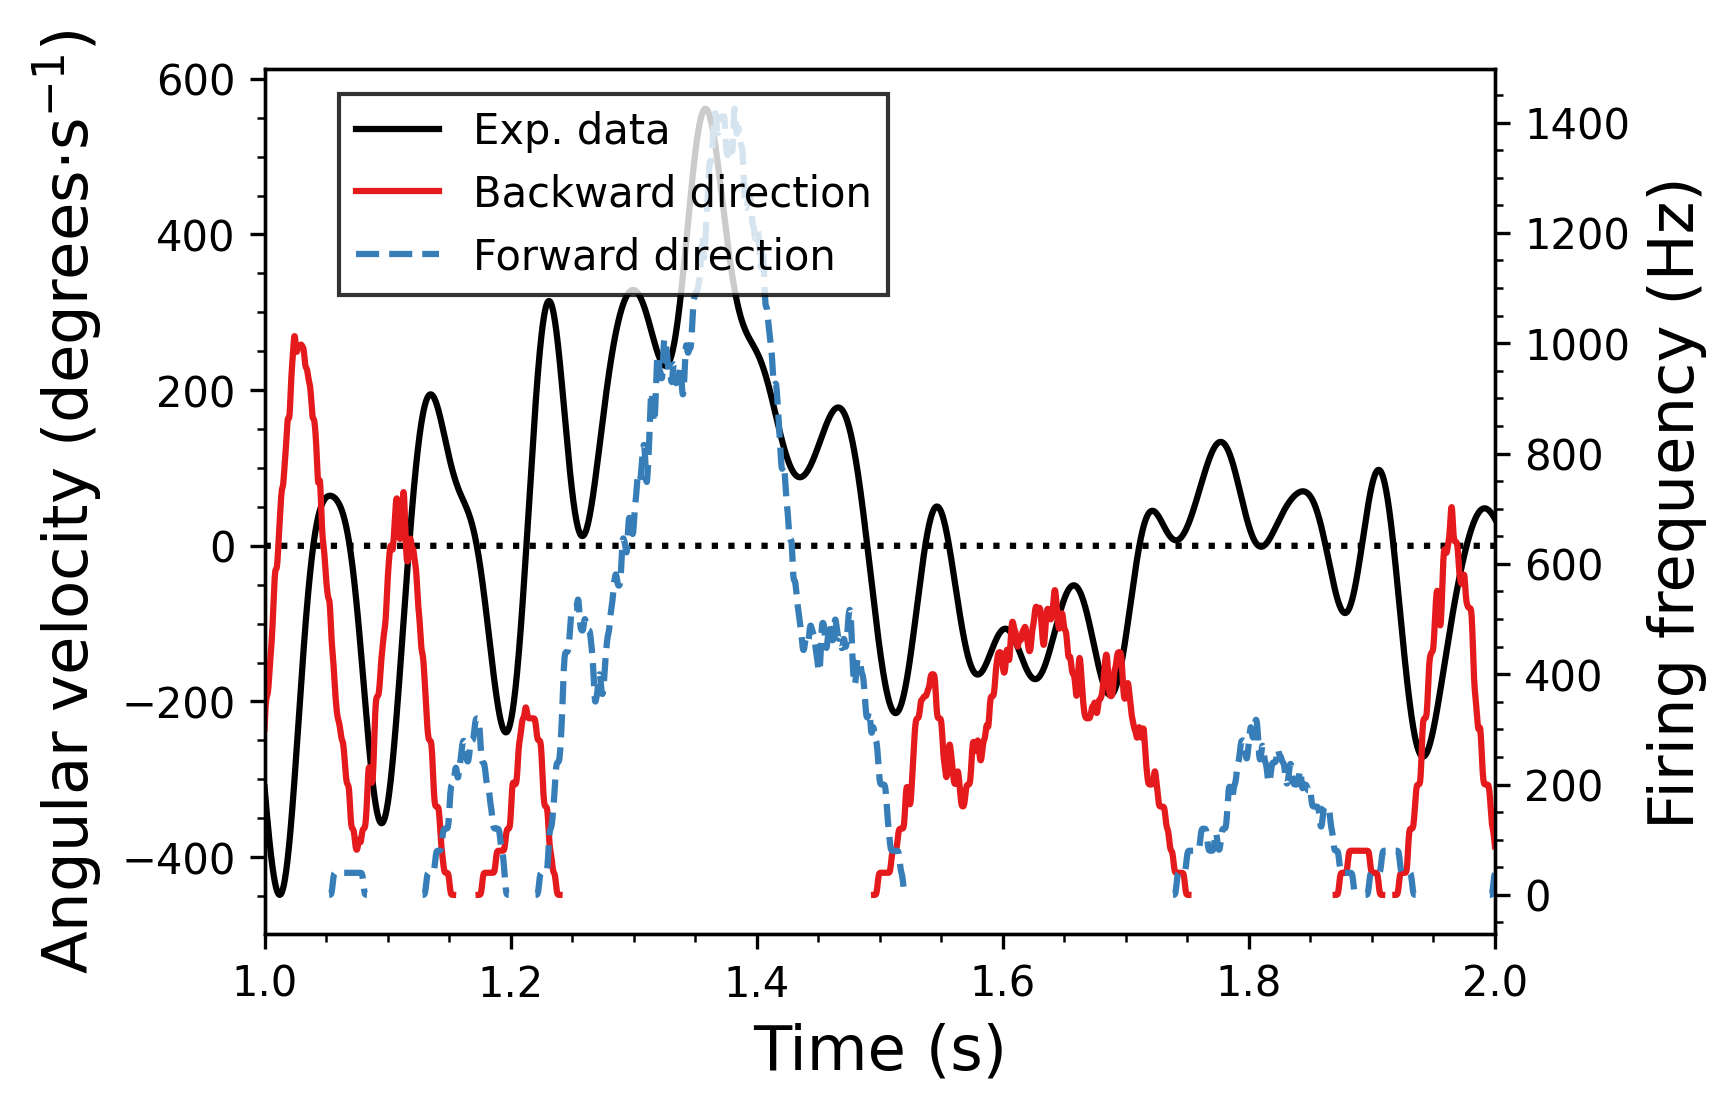

In [206]:
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 
    
joint_angles = joint_angles_nostep[:, :, 0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate_down = get_firing_rate_convolve(spike_motion[:, 0, 0], constants['dt'], t=0.025)
firing_rate_up = get_firing_rate_convolve(spike_motion[:, 1, 0], constants['dt'], t=0.025)

ax1.plot(time[1:], np.diff(joint_angles[:, 0]) / constants['dt'], color='black', linestyle=custom_linestyles[0], label='Exp. data')
ax2.plot(time, firing_rate_down, color=custom_colors[0], linestyle=custom_linestyles[0], label='Backward direction')
ax2.plot(time, firing_rate_up, color=custom_colors[1], linestyle=custom_linestyles[1], label='Forward direction')
ax1.plot(time, np.full(time.size, 0), color='black', linestyle='dotted')

ax1.set_xlim([1, 2])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angular velocity (degrees$\cdot$s$^{-1}$)")
ax2.set_ylabel("Firing frequency (Hz)")

ax1.minorticks_on()
ax2.minorticks_on()

fig.legend(loc='upper left', fancybox=False, edgecolor='black', bbox_to_anchor=[0.18, 0.97])

fig.tight_layout(pad=0.5)
fig.savefig('images/motion_neuron/motion_binary.png')
fig.savefig('images/motion_neuron/motion_binary.pdf')

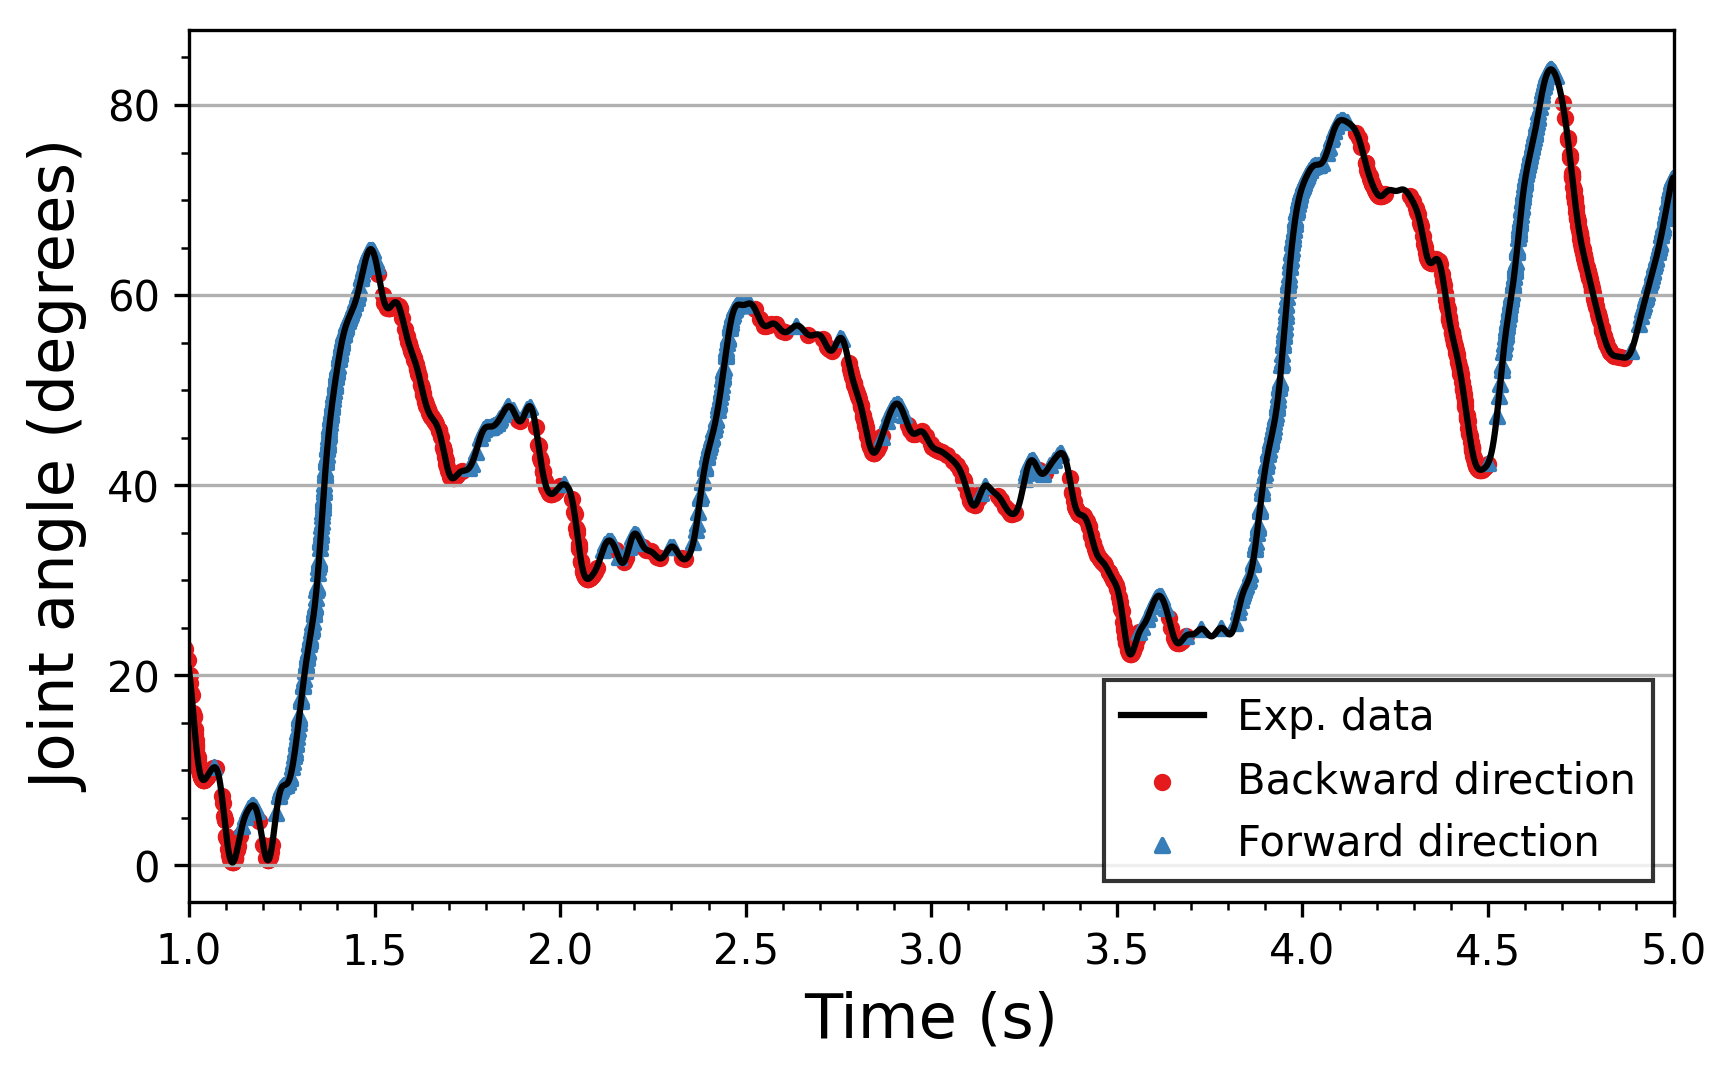

In [207]:
spike_motion[spike_motion == 0] = np.nan

fig, ax = plt.subplots()

plt.plot(time, joint_angles[:, 0], color='black')
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 0, 0], color=custom_colors[0], marker=custom_markers[0], s=10)
plt.scatter(time, joint_angles[:, 0] * spike_motion[:, 1, 0], color=custom_colors[1], marker=custom_markers[1], s=10)

ax.set_xlim([1, 5])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (degrees)")

ax.grid(axis='y', zorder=0)

ax.minorticks_on()

ax.legend(['Exp. data', 'Backward direction', 'Forward direction'], fancybox=False, edgecolor='black')

fig.tight_layout(pad=0.5)
fig.savefig('images/motion_neuron/movement_interneuron_network.png')
fig.savefig('images/motion_neuron/movement_interneuron_network.pdf')

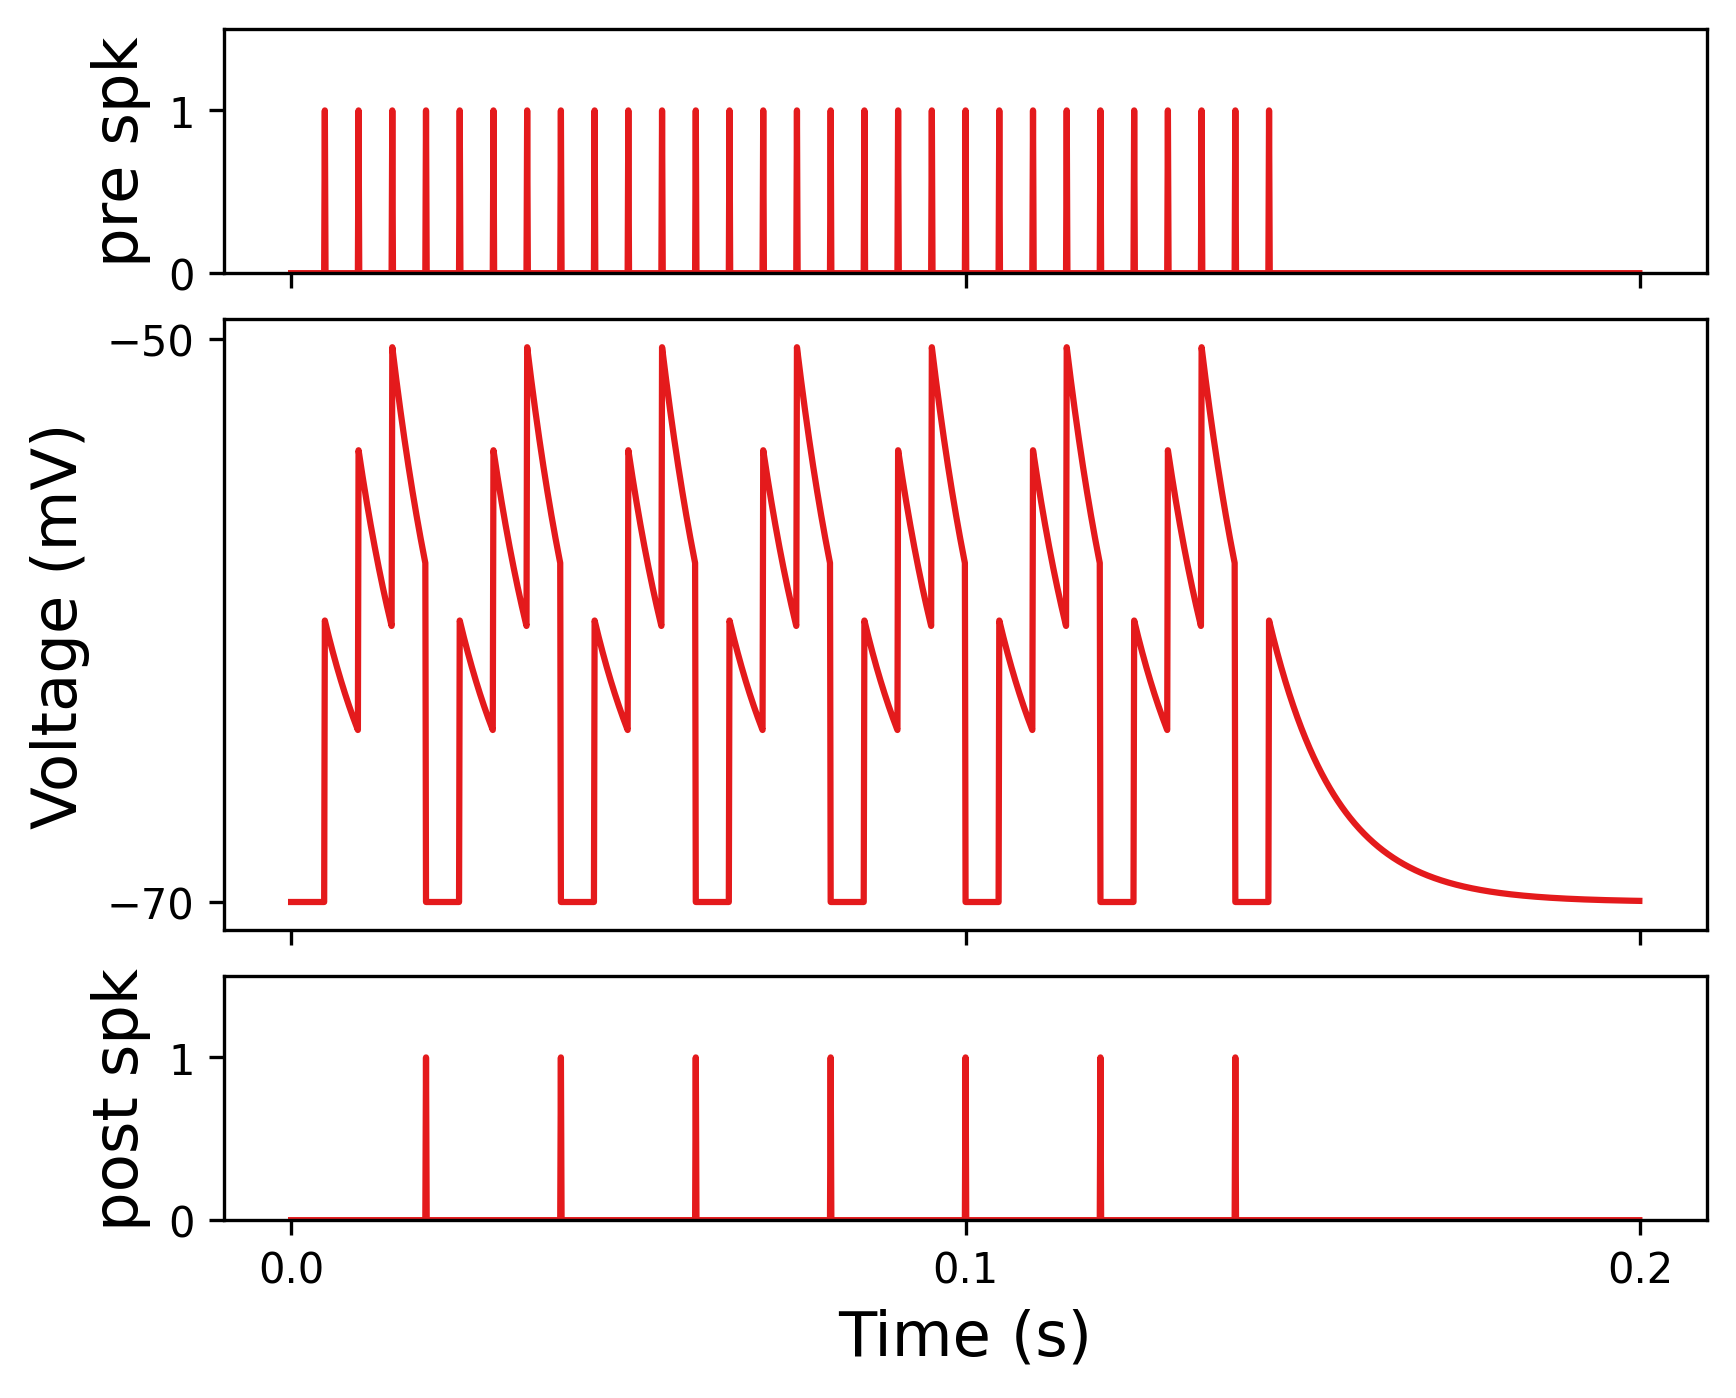

In [208]:
fig, [ax, ax2, ax3] = plt.subplots(3, figsize=(5.728, 1.3*3.54), gridspec_kw={'height_ratios': [1, 2.5, 1]}, sharex='all')
plt.subplots_adjust(wspace=0, hspace=0.05)

motion_parameters = {'tau': 10e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 1, 'w': 10e-3,
                     'N_input': 1, 'dt': 0.0001, 'refrac': 0}

motion_neuron = MotionNeuron(motion_parameters)

motion_neuron.initialize_state()

input = np.zeros(2000)
input[50:1500][::50] = 1

voltage, spikes, time = np.zeros(input.size), np.zeros(input.size), np.zeros(input.size)

for i in range(input.size):
    voltage[i], spikes[i] = motion_neuron.forward(input[i])
    time[i] = i*0.0001 
    
ax.plot(time, input, color=custom_colors[0])    

ax.set_ylabel("pre spk")
ax.set_yticks([0, 1])
ax.set_xticks([0, 0.1, 0.2])
ax.set_ylim(0, 1.5)

ax2.plot(time, voltage*1000, color=custom_colors[0])

ax2.set_ylabel("Voltage (mV)")
ax2.set_yticks([-70, -50])

ax3.plot(time, spikes, color=custom_colors[0])

ax3.set_ylabel("post spk")
ax3.set_yticks([0, 1])
ax3.set_xlabel("Time (s)")
ax3.set_ylim(0, 1.5)
               
fig.tight_layout(pad=0.5)
fig.savefig('images/motion_neuron/LIF_dynamics.png')
fig.savefig('images/motion_neuron/LIF_dynamics.pdf')